# Import Scripts and Libraries

In [1]:
# Standard imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, sys, cv2

# ProDiVis-specific imports
import norm_heatmap
import normalize
import tools
import heatmap_workflow_tools as hwt

# 1 - Setting up Filesystem
### *User input required!*

Before running the code, please ensure your filesystem consists of a parent directory with the ProDiVis repository and any dataset repositories cloned within. An example filesystem could look like the following:


`📁<parent_directory>`
```
└── 📁ProDiVis
    └──📁Scripts 
        └── Data_Pipeline.ipynb
        └── *.py
    └──📁data
        └──📁signal_stack
        └──📁normalization_stack
```

`└── 📁ProDiVis_Images` <span style="color:green"><em># clone if desired</em></span>

The repositories containing the glioblastoma and mouse heart datasets can be found at the links below:
 - [**ProDiVis_Images**](https://github.com/FrancoLaboratory/ProDiVis-Images)


In [2]:
# In quotes, type the path to the directory containing the ProDiVis repository:
WORKING_DIRECTORY = "/Users/Kyle/Desktop/prodivis_publish/"

# What is your signal of interest (SOI) and normalization signal (NS) 
SOI = "Mesoderm"
NS = "DAPI"

# Replace with slice integers or decimal percentages. 'None' for no boundary
ZMIN, ZMAX = None, None

# Do you want to multiply the pixels in the front and side views (int)?
Z_MULTIPLIER = 10

# Do you want to save your figures? (boolean)
SAVE_FIGS = False

# Adjust the lower and upper threshold (int). 'None' to use bit-depth of input images
LOWER_THRESH = 5
UPPER_THRESH = 254

In [3]:
selection = tools.get_int_input(hwt.SELECTION_PROMPT, 1, 2)

# 2. Pre-Analysis

In [4]:
if selection == 1:
    DATA_DIRECTORY = os.path.join(WORKING_DIRECTORY, "ProDiVis", "data")
elif selection == 2:
    DATA_DIRECTORY = os.path.join(WORKING_DIRECTORY, "ProDiVis_Images", "Cluster_Actin")
else:
    raise ValueError(f"Selection {selection} not recognized")

STACK_DIR = os.path.join(DATA_DIRECTORY, "signal_stack")
NORM_DIR = os.path.join(DATA_DIRECTORY, "normalization_stack")

In [5]:
stack_tiffs = tools.get_files(STACK_DIR, exclude_ext = ['.md', '.DS'])
norm_tiffs = tools.get_files(NORM_DIR, exclude_ext = ['.md', '.DS'])

ZMIN, ZMAX = hwt.process_zmin_zmax(ZMIN, ZMAX, stack_tiffs)
print(f"Processed ZMin and ZMax: {ZMIN}, {ZMAX}")

stack_name = SOI #os.path.basename(STACK_DIR)
norm_name = NS #os.path.basename(NORM_DIR)
base_dir = DATA_DIRECTORY #os.path.basename(os.path.dirname(NORM_DIR))

EXPORT_DIRECTORY = os.path.abspath(os.path.join(os.path.abspath(''), '..', 'exported_data'))
if not os.path.isdir(EXPORT_DIRECTORY):
    os.makedirs(EXPORT_DIRECTORY, exist_ok=True)

OUTPUT_DIRECTORY = os.path.join(EXPORT_DIRECTORY, f"EXPORT_{base_dir}_{stack_name}n{norm_name}")
if not os.path.isdir(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)

Processed ZMin and ZMax: 0, 51


In [6]:
# Checking filesystem
for directory in [WORKING_DIRECTORY, STACK_DIR, NORM_DIR, OUTPUT_DIRECTORY]:
    try:
        assert os.path.isdir(directory)
    except:
        raise AssertionError(f"Directory of path {directory} was not found. Please validate user inputs in above cells and ensure filesystem matches that depicted above before moving forward.")
        sys.exit()

# Begin Analysis

### Determine Images Above Threshold

#### Normalization Signal

In [7]:
norm_imgs = normalize.analyze_images(norm_tiffs, LOWER_THRESH)
norm_imgs = normalize.images_used(norm_imgs, norm_tiffs, stack_tiffs)

/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/normalization_stack/dapi_Z0000.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/normalization_stack/dapi_Z0001.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/normalization_stack/dapi_Z0002.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/normalization_stack/dapi_Z0003.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/normalization_stack/dapi_Z0004.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/normalization_stack/dapi_Z0005.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/normalization_stack/dapi_Z0006.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/normalization_stack/dapi_Z0007.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/normalization_stack/dapi_Z0008.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/normalization_stack/dapi_Z0009.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/normalization_stack/dapi_Z0010.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/nor

#### Signal of Interest

In [8]:
SOI_imgs = normalize.analyze_images(stack_tiffs, LOWER_THRESH)
SOI_imgs = normalize.images_used(SOI_imgs, norm_tiffs, stack_tiffs)

/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/signal_stack/mesoderm_Z0000.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/signal_stack/mesoderm_Z0001.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/signal_stack/mesoderm_Z0002.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/signal_stack/mesoderm_Z0003.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/signal_stack/mesoderm_Z0004.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/signal_stack/mesoderm_Z0005.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/signal_stack/mesoderm_Z0006.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/signal_stack/mesoderm_Z0007.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/signal_stack/mesoderm_Z0008.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/signal_stack/mesoderm_Z0009.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/signal_stack/mesoderm_Z0010.tif
/Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/signal_stack/mesoderm_Z0011.tif
/Use

# Visualise Image Histograms and Distribution

#### SOI Depth Loss

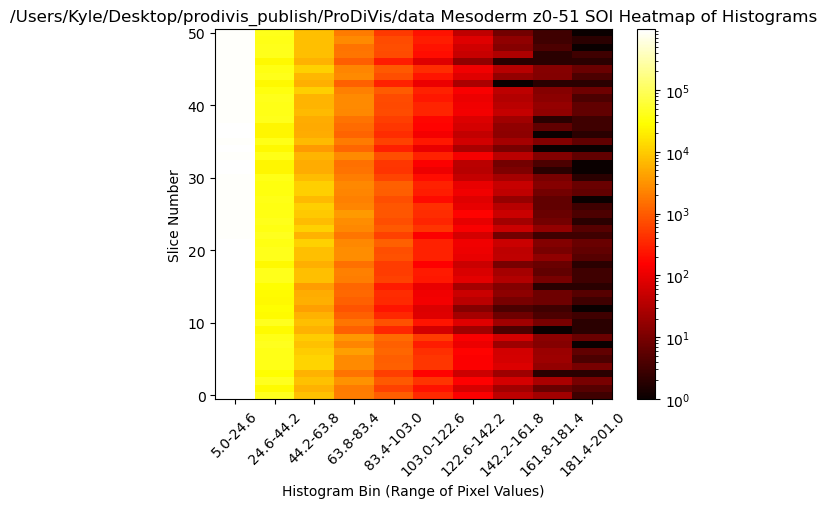

In [9]:
nbins = 10
histograms = np.zeros((len(stack_tiffs[ZMIN:ZMAX]), nbins))
for idx, img in enumerate(stack_tiffs[ZMIN:ZMAX]):
    tiff = normalize.thresh(img, LOWER_THRESH, UPPER_THRESH, 1)
    hist, bins = np.histogram(tiff, bins = nbins)
    histograms[idx] = hist
histograms[histograms == 0] = 1
bin_labels = ["{}-{}".format(round(bins[i-1],1), round(bins[i],1)) for i in range(1, len(bins))]
hwt.plot_histograms(histograms, f"{base_dir} {stack_name} z{ZMIN}-{ZMAX} SOI Heatmap of Histograms",
os.path.join(OUTPUT_DIRECTORY, f"{base_dir}_{stack_name}_z{ZMIN}-{ZMAX}_SOI_Histograms.pdf"), bin_labels, SAVE_FIGS)

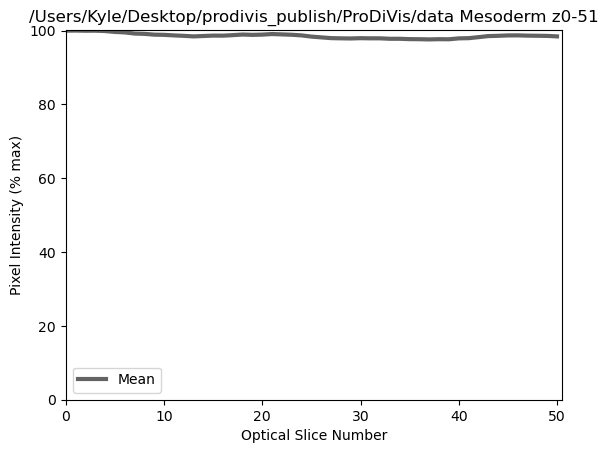

In [10]:
stack_means = np.array([])
for img in stack_tiffs[ZMIN:ZMAX]:
    mean = normalize.tiff_stats_thresh(img, LOWER_THRESH, UPPER_THRESH, 1)
    stack_means = np.append(stack_means, mean)
hwt.plot_MSI(stack_means,
             f"{base_dir} {stack_name} z{ZMIN}-{ZMAX}",
             os.path.join(OUTPUT_DIRECTORY, f"{base_dir}_{stack_name}_z{ZMIN}-{ZMAX}_SOI_Intensity.pdf"), SAVE_FIGS)

### NS Depth Loss

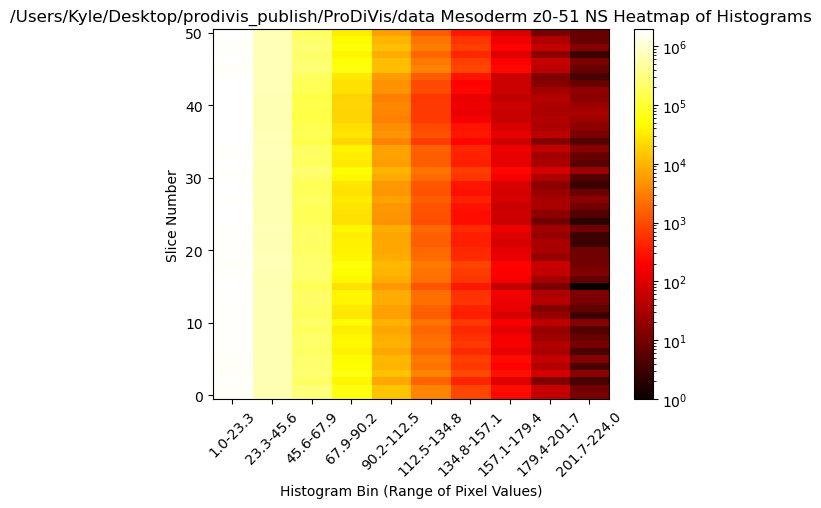

In [11]:
nbins = 10
histograms = np.zeros((len(stack_tiffs[ZMIN:ZMAX]), nbins))
for idx, img in enumerate(norm_tiffs[ZMIN:ZMAX]):
    tiff = normalize.thresh(img, 0, 254, 1)
    hist, bins = np.histogram(tiff, bins = nbins)
    histograms[idx] = hist
histograms[histograms == 0] = 1
bin_labels = ["{}-{}".format(round(bins[i-1],1), round(bins[i],1)) for i in range(1, len(bins))]
hwt.plot_histograms(histograms, f"{base_dir} {stack_name} z{ZMIN}-{ZMAX} NS Heatmap of Histograms",
os.path.join(OUTPUT_DIRECTORY, f"{base_dir}_{stack_name}_z{ZMIN}-{ZMAX}_NS_Histograms.pdf"), bin_labels, SAVE_FIGS)

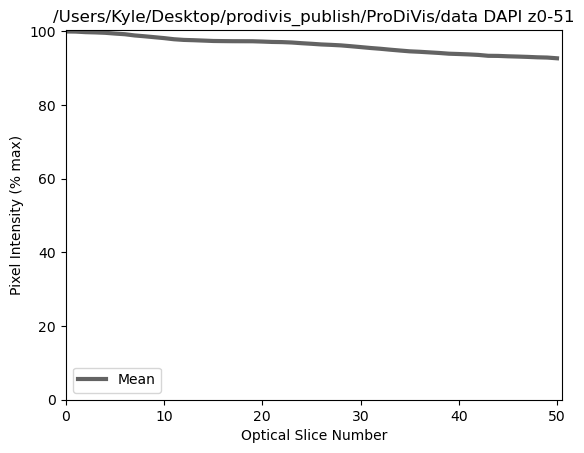

In [12]:
norm_means = np.array([])
for norm_tiff in norm_tiffs[ZMIN:ZMAX]:
    mean = normalize.tiff_stats_thresh(norm_tiff, 0, 254, 1)
    norm_means = np.append(norm_means, mean)
hwt.plot_MSI(norm_means,
             f"{base_dir} {norm_name} z{ZMIN}-{ZMAX}",
             os.path.join(OUTPUT_DIRECTORY, f"{base_dir}_{stack_name}_z{ZMIN}-{ZMAX}_NS_Intensity.pdf"), SAVE_FIGS)

### NS vs SOI

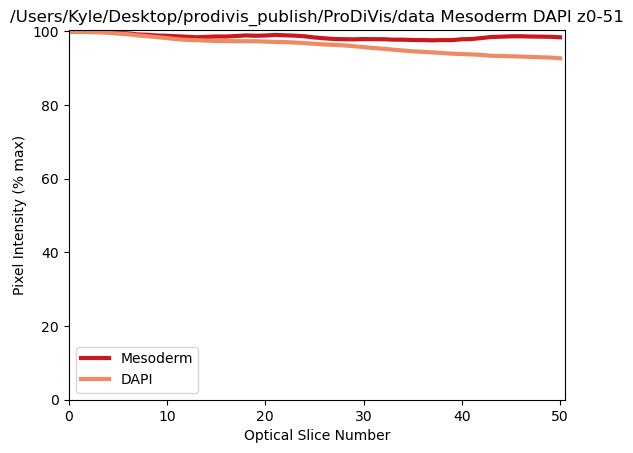

In [13]:
hwt.plot_MSI_soi_ns(SOI, NS, stack_means, norm_means, f"{base_dir} {stack_name} {norm_name} z{ZMIN}-{ZMAX}",
             os.path.join(OUTPUT_DIRECTORY, f"{base_dir}_{stack_name}n{norm_name}_z{ZMIN}-{ZMAX}_SOI_vs_NS.pdf"), SAVE_FIGS)

# SNIP Raw Heatmap

In [14]:
imgs = norm_heatmap.stack(stack_tiffs[ZMIN:ZMAX], ['z', 'x', 'y'], Z_MULTIPLIER)
hwt.plot_MIP(imgs, f"{base_dir} {stack_name} z{ZMIN}-{ZMAX}", 
                os.path.join(OUTPUT_DIRECTORY, f"{base_dir}_{stack_name}_z{ZMIN}-{ZMAX}_HeatMap.pdf"), SAVE_FIGS)

Generating composites for z, x and y view(s) from /Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/signal_stack...
Completing post-processing for z, x and y composite(s) from /Users/Kyle/Desktop/prodivis_publish/ProDiVis/data/signal_stack...
Error in callback <function _draw_all_if_interactive at 0x11bce30a0> (for post_execute):


FloatingPointError: overflow encountered in scalar multiply

FloatingPointError: overflow encountered in scalar multiply

<Figure size 640x480 with 3 Axes>

# Normalization

In [ ]:
norm_stack_tiffs = normalize.mean_normalizer(stack_tiffs[ZMIN:ZMAX], norm_tiffs[ZMIN:ZMAX], LOWER_THRESH, UPPER_THRESH, True, False)

#### Pixel Distribution Post-Normalization

In [ ]:
norm_stack_means = np.array([])
for norm_stack_tiff in norm_stack_tiffs[ZMIN:ZMAX]:
    mean = normalize.tiff_stats_thresh(norm_stack_tiff, 0, 255, 1)
    norm_stack_means = np.append(norm_stack_means, mean)
hwt.plot_MSI(norm_stack_means,
             f"{base_dir} {stack_name} norm {norm_name} z{ZMIN}-{ZMAX}",
             os.path.join(OUTPUT_DIRECTORY, f"{base_dir}_{stack_name}n{norm_name}_z{ZMIN}-{ZMAX}_Normalized_SOI_Intensity.pdf"), SAVE_FIGS)

hwt.plot_MSI_grouped(stack_means, norm_means, norm_stack_means, f"{base_dir} {stack_name} norm {norm_name} z{ZMIN}-{ZMAX}_Grouped",
                os.path.join(OUTPUT_DIRECTORY, f"{base_dir}_{stack_name}n{norm_name}_z{ZMIN}-{ZMAX}_Normalized_Intensity_grouped.pdf"), SAVE_FIGS)

# SNIP Normalized Heatmap

In [ ]:
imgs = norm_heatmap.stack(norm_stack_tiffs[ZMIN:ZMAX], ['z', 'x', 'y'], Z_MULTIPLIER)
hwt.plot_MIP(imgs, f"{base_dir} {stack_name} norm {norm_name} z{ZMIN}-{ZMAX}", 
                os.path.join(OUTPUT_DIRECTORY, f"{base_dir}_{stack_name}n{stack_name}_z{ZMIN}-{ZMAX}_Normalized_HeatMap.pdf"), SAVE_FIGS)

# Image Rescaling

In [ ]:
tools.stack_gui(norm_stack_tiffs, norm_tiffs)

#### Insert Path to Scaled Images

In [ ]:
scaled_norm_stack_tiffs = os.path.abspath("/Users/Kyle/Desktop/prodivis_public_repo/prodivis/sample_data/scaled_green_SOI_rn_blue_ns_254std_nblue_ns")
scaled_norm_stack_tiffs = tools.get_files(scaled_norm_stack_tiffs)

#### Pixel Distribution of Scaled Images

In [ ]:
nbins = 10
histograms = np.zeros((len(scaled_norm_stack_tiffs[ZMIN:ZMAX]), nbins))
for idx, img in enumerate(scaled_norm_stack_tiffs[ZMIN:ZMAX]):
    tiff = normalize.thresh(img, 0, 255, 1)
    hist, bins = np.histogram(tiff, bins = nbins)
    histograms[idx] = hist
histograms[histograms == 0] = 1
bin_labels = ["{}-{}".format(round(bins[i-1],1), round(bins[i],1)) for i in range(1, len(bins))]
hwt.plot_histograms(histograms, f"{base_dir} {stack_name} z{ZMIN}-{ZMAX} Normalized SOI Heatmap of Histograms",
os.path.join(OUTPUT_DIRECTORY, f"{base_dir}_{stack_name}_z{ZMIN}-{ZMAX}_Scaled_Normalized_SOI_Histograms.pdf"), bin_labels, SAVE_FIGS)

#### Normalized Depth Loss of Scaled Images

In [ ]:
scaled_norm_stack_means = np.array([])
for scaled_norm_stack_tiff in scaled_norm_stack_tiffs[ZMIN:ZMAX]:
    mean = normalize.tiff_stats_thresh(scaled_norm_stack_tiff, 0, 255, 1)
    scaled_norm_stack_means = np.append(scaled_norm_stack_means, mean)
hwt.plot_MSI(scaled_norm_stack_means,
             f"Scaled_{base_dir} {stack_name} norm {norm_name} z{ZMIN}-{ZMAX}_",
             os.path.join(OUTPUT_DIRECTORY, f"{base_dir}_{stack_name}n{norm_name}_z{ZMIN}-{ZMAX}_Scaled_Normalized_SOI_Intensity.pdf"), SAVE_FIGS)

# SNIP Normalized Heatmap of Scaled Images

In [ ]:
scaled_imgs = norm_heatmap.stack(scaled_norm_stack_tiffs[ZMIN:ZMAX], ['z', 'x', 'y'], Z_MULTIPLIER)
hwt.plot_MIP(scaled_imgs, f"{base_dir} {stack_name} norm {norm_name} z{ZMIN}-{ZMAX}", 
                os.path.join(OUTPUT_DIRECTORY, f"{base_dir}_{stack_name}n{stack_name}_z{ZMIN}-{ZMAX}_Scaled_Normalized_HeatMap.pdf"), SAVE_FIGS)